In [1]:
# -*- coding: utf-8 -*-
"""
Created on Mon Apr 05 2020 20:42:18 

@author: S.M.Ali Mousavi
"""

'\nCreated on Mon Apr 05 2020 20:42:18 \n\n@author: S.M.Ali Mousavi\n'

In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import import_ipynb
%matplotlib inline
# matplotlib.rcParams['figure.dpi'] = 144

In [3]:
import random 
import torch 

In [4]:

# from nbeats_keras.model import NBeatsNet
# from numpy import linalg as LA
# # from sklearn.utils import check_arrays
# from statsmodels.tsa.arima_model import ARIMA
# from pandas import DataFrame
# from pandas import concat

In [5]:
##########################Load Libraries  ####################################
# import dask.dataframe as dd
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.max_rows', 500)
import seaborn as sns
# import lightgbm as lgb
# from sklearn import preprocessing, metrics
# from ipywidgets import widgets, interactive
# import gc
# import joblib
# import warnings
# warnings.filterwarnings('ignore')
# from datetime import datetime, timedelta 
# from typing import Union
# from tqdm.notebook import tqdm_notebook as tqdm
# from itertools import cycle
import datetime as dt
from torch.autograd import Variable

# import os
# from matplotlib.pyplot import figure
from fastprogress import master_bar, progress_bar
# import torch
import torch.nn as nn

# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# import time 
# from torch.utils.data import Dataset
# from sklearn.metrics import mean_squared_error



#from gensim.models import Word2Vec
#import gensim.downloader as api

# pd.set_option('max_columns', 50)
# plt.style.use('bmh')
# color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
# color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])


In [6]:
import LevelsCreator as lc

importing Jupyter notebook from LevelsCreator.ipynb


- Main Steps
- Load Data
- One Time Series
- Normlize Data
- Create Sequances
- Simple LSTM model
- Multiple LSTM layers
- Add Features

# Seeding

In [7]:
SEED = 1345
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


seed_everything(SEED)

# CPU/GPU allocation ?

In [8]:
# device = 'cuda:0'
device = 'cpu'

# HF: Reducing the memory size of the input data

In [10]:
INPUT_DIR_PATH = 'Data/'

In [11]:
def reduce_mem_usage(df, verbose=True):
    '''Reducing memory usage of the input data'''
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics: 
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df


def read_data():
    sell_prices_df = pd.read_csv(INPUT_DIR_PATH + 'sell_prices.csv')
    sell_prices_df = reduce_mem_usage(sell_prices_df)
    print('Sell prices has {} rows and {} columns'.format(sell_prices_df.shape[0], sell_prices_df.shape[1]))

    calendar_df = pd.read_csv(INPUT_DIR_PATH + 'calendar.csv')
    calendar_df = reduce_mem_usage(calendar_df)
    print('Calendar has {} rows and {} columns'.format(calendar_df.shape[0], calendar_df.shape[1]))

    sales_train_validation_df = pd.read_csv(INPUT_DIR_PATH + 'sales_train_validation.csv')
    print('Sales train validation has {} rows and {} columns'.format(sales_train_validation_df.shape[0], sales_train_validation_df.shape[1]))

    submission_df = pd.read_csv(INPUT_DIR_PATH + 'sample_submission.csv')
    return sell_prices_df, calendar_df, sales_train_validation_df, submission_df
    

# Load Data (calling the data memory reductor function)

In [12]:
_,  calendar_df, sales_train_validation_df, _ = read_data()

Mem. usage decreased to 130.48 Mb (37.5% reduction)
Sell prices has 6841121 rows and 4 columns
Mem. usage decreased to  0.12 Mb (41.9% reduction)
Calendar has 1969 rows and 14 columns
Sales train validation has 30490 rows and 1919 columns


# Data wrangling

## Create date index

In [51]:
#Create date index
date_index = calendar_df['date']
dates = date_index[0:1913]
dates_list = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in dates]

## HC: Level Creator

In [52]:
class LevelsCreator:
    def __init__(self):
        pass
    
    def level_11(self,sales_data):
        df = sales_data.groupby(['item_id', 'state_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_10(self,sales_data):
        df= sales_data.groupby(['item_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    
    def level_9(self,sales_data):
        df= sales_data.groupby(['store_id', 'dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    
    def level_8(self,sales_data):
        df= sales_data.groupby(['store_id', 'cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    
    def level_7(self,sales_data):
        df= sales_data.groupby(['state_id', 'dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_6(self,sales_data):
        df= sales_data.groupby(['state_id', 'cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_5(self,sales_data):
        df= sales_data.groupby(['dept_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_4(self,sales_data):
        df= sales_data.groupby(['cat_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_3(self,sales_data):
        df= sales_data.groupby(['store_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_2(self,sales_data):
        df= sales_data.groupby(['state_id'], as_index=False).sum()
        return df.set_index(df.columns[0])
    def level_1(self,sales_data):
        df= (pd.DataFrame(self.level_2(sales_data).sum())).transpose()
        return df   

## Select One Time Series as an Example 

In [53]:
## using the level creator module to make a level
df3= pd.DataFrame()
df3= LevelsCreator().level_3(sales_train_validation_df).T  #making level 3 here #! Data transposed to have the dates in column
#Set Dates as index 
DF_Sales = pd.DataFrame(df3).set_index([dates_list])
DF_Sales.index = pd.to_datetime(DF_Sales.index) #?## wasn't it already datetime?
DF_Sales.rename_axis('date', axis=1, inplace=True) # Renaming the index column from store_id to days
DF_Sales.head()

date,CA_1,CA_2,CA_3,CA_4,TX_1,TX_2,TX_3,WI_1,WI_2,WI_3
2011-01-29,4337,3494,4739,1625,2556,3852,3030,2704,2256,4038
2011-01-30,4155,3046,4827,1777,2687,3937,3006,2194,1922,4198
2011-01-31,2816,2121,3785,1386,1822,2731,2225,1562,2018,3317
2011-02-01,3051,2324,4232,1440,2258,2954,2169,1251,2522,3211
2011-02-02,2630,1942,3817,1536,1694,2492,1726,2,1175,2132


In [54]:
# ## This cell is what the original code used: https://www.kaggle.com/omershect/learning-pytorch-lstm-deep-learning-with-m5-data
# # Create a data frame for items sales per day with item ids (with Store Id) as columns names  and dates as the index 
# sales_train_validation_df['item_store_id'] = sales_train_validation_df.apply(lambda x: x['item_id']+'_'+x['store_id'],axis=1)
# DF_Sales = sales_train_validation_df.loc[:,'d_1':'d_1913'].T
# DF_Sales.columns = sales_train_validation_df['item_store_id'].values

# #Set Dates as index 
# DF_Sales = pd.DataFrame(DF_Sales).set_index([dates_list])
# DF_Sales.index = pd.to_datetime(DF_Sales.index)
# DF_Sales.head()

## Exploring the selected time serie

In [55]:
# print(f'Select an arbiterary "index" to take out a sample Time Series from 0 to {DF_Sales.size()[1]}')
# index = 200

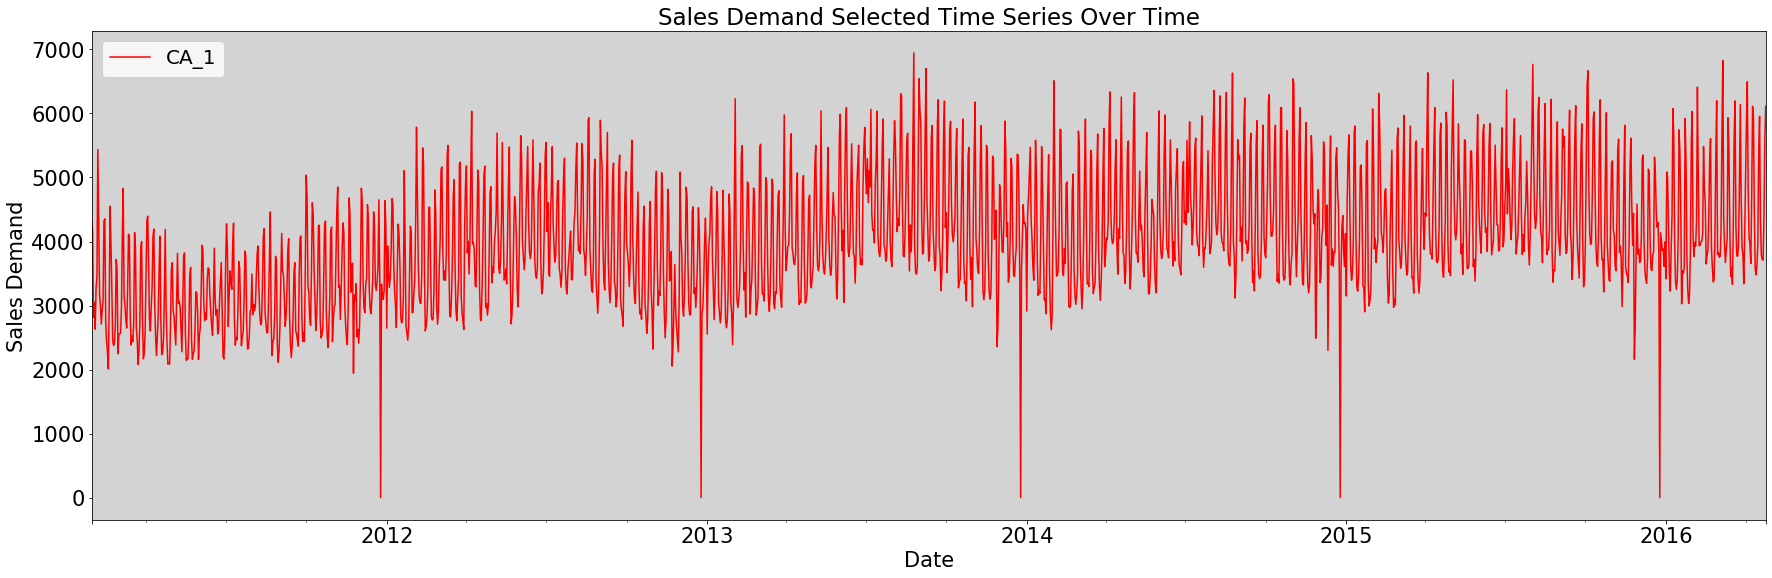

In [56]:
# index = 6780 #select arbiterary time series in the data set
y = pd.DataFrame(DF_Sales.iloc[:,0])    ##?!## wasn't it already DataFrame?
y = pd.DataFrame(y).set_index([dates_list])
TS_selected = y 
y.index = pd.to_datetime(y.index) ##?!## wasn't it already datetime?
ax = y.plot(figsize=(30, 9),color='red') ##?!## isn't it better to use fig instead of ax?
ax.set_facecolor('lightgrey')
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.legend(fontsize=20)
plt.title(label = 'Sales Demand Selected Time Series Over Time',fontsize = 23)
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

## Normlization/Regularization/Outlier removal step

### Normalization

In [57]:
from sklearn.preprocessing import MinMaxScaler

In [58]:
y = pd.DataFrame(DF_Sales.iloc[:,0])    #Column 0 of level_3.T is CA_1
y = pd.DataFrame(y).set_index([dates_list])

#Normalization of your choice, in this cell MinMaxScaler from Sklearn is used 
# data = np.array(y) ##?!## can't we just take the values? it will give a pd.Series.serie type Series 
scaler = MinMaxScaler(feature_range=(-1, 1))  #range of normalization set to -1 to 1
train_data_normalized = scaler.fit_transform(y) # data.reshape(-1, 1)

In [59]:
# #Run this cell for a rough sanity check of the normalization 
# print(train_data_normalized[:5])
# print(train_data_normalized[-5:])

### Stabilization

### Plotting distributation before and after processing for sanity check

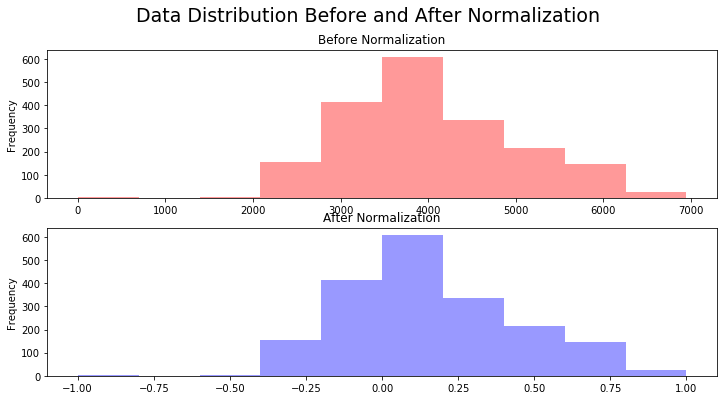

In [60]:
fig, axs = plt.subplots(2)
 
fig.suptitle('Data Distribution Before and After Normalization ',fontsize = 19)
pd.DataFrame(y).plot(kind='hist',ax = axs[0] , alpha=.4 , figsize=[12,6], \
                     legend = False, title = 'Before Normalization',color ='red') 
pd.DataFrame(train_data_normalized).plot(kind='hist', ax = axs[1], alpha=.4, figsize=[12,6], \
                     legend = False, title = 'After Normalization',color = 'blue')

## Change the time series to supervised problem/Create Sequances

### Image: Sliding and Expanding Window concept

![Sliding_Expanding_Window](images/Sliding_Expandiwn_Window.png)
![Sliding_Window](images/Sliding_Window.png)

#### Impelemntation of Sliding window with 6days input window in a DataFrame
![Sliding_Window_6_Column](images/Sliding_Window_6_Column.PNG)

### Sliding Windoes method

In [61]:
###  This function creates a sliding window or sequences of 28 days and one day label ####
def sliding_windows(data, window_length):
    '''Takes a data frame and windows length as input. 
    The input data should be in form of (#observation) x (1LabelColumn) '''
    x = []
    y = []

    for i in range(len(data)-window_length-1):
        _x = data[i:(i+window_length)]
        _y = data[i+window_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [62]:
#train_inout_seq = create_inout_sequences(train_data_normalized, train_window)
window_length = 28
x, y = sliding_windows(train_data_normalized, window_length)
print(x.shape)
print(y.shape)

(1884, 28, 1)
(1884, 1)


### HF: series_to_supervised

In [63]:
def series_to_supervised_l3(data, store='CA_1', n_in=1, n_out=1, dropnan=False):

    n_vars = 1 if type(data) is list else data.shape[1]
    data_shifted=pd.DataFrame()
    names=list()
    # Selecting a store of interest, 
    # Transposing the days from being column to being the index
    data=data.loc[[store]].T
    
    # looping over the lag window(n_in) and making a new column
    for i in range(n_in, 0, -1):
        df=pd.DataFrame() #is this step necessary ?
        col_shifted=data.shift(i)
        col_shifted.columns=[f'{store}_t-{i}']
        data_shifted = pd.concat([data_shifted,col_shifted], axis=1, sort=False)

#     data_shifted.columns=col_names
    
#     for i in range(0, n_out):
#         df=pd.DataFrame()
#         names=list()
#         df=data.shift(-i)
#         if i == 0:
#             names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
#         else:
#             names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
            
#         df.columns=names
#         cols=pd.concat([cols,df],axis=1,sort=False)
    
    # dropping the Nans if dropnan=True
    
    if dropnan:
        data_shifted.dropna(inplace=True)
        
  
    #reseting index from d_1...d_1913 to o...1912
    data_shifted.reset_index(drop=True, inplace=True)   
    # Renaming the index column from store_id to days
    data_shifted.rename_axis('days', axis=1, inplace=True) 
    
    return data_shifted

### Sujal Sliding Widnows

In [64]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=False):

    n_vars = 1 if type(data) is list else data.shape[1]
    cols=pd.DataFrame()
    names=list()
    for i in range(n_in, 0, -1):
        df=pd.DataFrame()
        names=list()
        df=data.shift(i)
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]
        df.columns=names
        cols = pd.concat([cols, df], axis=1, sort=False)
    for i in range(0, n_out):
        df=pd.DataFrame()
        names=list()
        df=data.shift(-i)
        if i == 0:
            names += [('%s(t)' % (data.columns[j])) for j in range(n_vars)]
        else:
            names += [('%s(t+%d)' % (data.columns[j], i)) for j in range(n_vars)]
            
        df.columns=names
        cols=pd.concat([cols,df],axis=1,sort=False)
    if dropnan:
        cols.dropna(inplace=True)
    return cols

def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [65]:
y = pd.DataFrame(DF_Sales.iloc[:,0])    #Column 0 of level_3.T is CA_1
y = pd.DataFrame(y).set_index([dates_list])
data = np.array(y)

## Splitting into train test sets

In [66]:
# split data into train test 
train_percentage = 0.67
train_size = int(len(y) * train_percentage)
test_size = len(y) - train_size

dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

### Let's check the shape of the splitted data

In [67]:
print("train shape is:",trainX.size())
print("train label shape is:",trainY.size())
print("test shape is:",testX.size())
print("test label shape is:",testY.size())

train shape is: torch.Size([1281, 28, 1])
train label shape is: torch.Size([1281, 1])
test shape is: torch.Size([603, 28, 1])
test label shape is: torch.Size([632, 1])


# Pytorch Tensors¶


Pytorch use tensors as the input to the model Variable is a wrapper to the tensor This kernel is only a preliminary starter,

The `Variable wrapper` has been used, however, a more common way is to train with batches and use the dataset class. Can be done later.

If you want to learn more about Tensors Read this tutorial

https://pytorch.org/tutorials/beginner/former_torchies/tensor_tutorial.html

# Simple LSTM model 

You can read more about LSTM at the nice visual explanation at the article by  : PUT_ARTICLE_LINK_HERE

<img src="images/LSTM_Simple_net.PNG" alt="drawing" width="500"/>
<!-- ![Simple LSTM](images/LSTM_Simple_net.PNG) -->

The following parameters are provided to the LSTM network

- Num-classes - is the number of output in this case 1
- Input size - we don't use batch, so we have one input (of 28 samples)
- Hidden layers, number of hidden layer in each cell, the more is better, but also will slow down the training
- Num layers - we have one layer of LSTM (layer we will increase it)

In [68]:
class LSTM(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        #self.seq_length = seq_length
        self.dropout = nn.Dropout(p=0.2)
        
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True,dropout = 0.25)
        
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
        # Propagate input through LSTM
        ula, (h_out, _) = self.lstm(x, (h_0, c_0))
        
        h_out = h_out.view(-1, self.hidden_size)
        
        out = self.fc(h_out)
        out = self.dropout(out)
       
        return out

In [69]:
# create a nn class (just-for-fun choice :-) 
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

# LSTM hyper parameters

In [75]:
#####  Parameters  ######################
num_epochs = 500
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 1
num_classes = 1

#####Init the Model #######################
lstm = LSTM(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)

##### Set Criterion Optimzer and scheduler ####################
criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=500,factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model
for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    
    optimizer.step()
    
    #Evaluate on test     
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(), vall_loss.cpu().item()))

RuntimeError: The size of tensor a (603) must match the size of tensor b (632) at non-singleton dimension 0

# Predict on Entire Data Set

In [ ]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

## Plot the test set

In [ ]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()

## Multiple LSTM layers

<img src="images/LSTM_Multiple_net.PNG" alt="drawing" width="500"/>

In [ ]:
class LSTM2(nn.Module):

    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM2, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        
        self.batch_size = 1
        #self.seq_length = seq_length
        
        self.LSTM2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers,batch_first=True,dropout = 0.25)
       
        
        
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(p=0.2)
    def forward(self, x):
        h_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
         
        
        c_1 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size).to(device))
        
       
        _, (hn, cn) = self.LSTM2(x, (h_1, c_1))
     
        #print("hidden state shpe is:",hn.size())
        y = hn.view(-1, self.hidden_size)
        
        final_state = hn.view(self.num_layers, x.size(0), self.hidden_size)[-1]
        #print("final state shape is:",final_state.shape)
        out = self.fc(final_state)
        #out = self.dropout(out)
        #print(out.size())
        return out

In [ ]:
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        

In [ ]:
num_epochs = 700
learning_rate = 1e-3
input_size = 1
hidden_size = 512
num_layers = 2

num_classes = 1

lstm = LSTM2(num_classes, input_size, hidden_size, num_layers)
lstm.to(device)


lstm.apply(init_weights)

criterion = torch.nn.MSELoss().to(device)    # mean-squared error for regression
optimizer = torch.optim.Adam(lstm.parameters(), lr=learning_rate,weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,  patience=100, factor =0.5 ,min_lr=1e-7, eps=1e-08)
#optimizer = torch.optim.SGD(lstm.parameters(), lr=learning_rate)

# Train the model

for epoch in progress_bar(range(num_epochs)): 
    lstm.train()
    outputs = lstm(trainX.to(device))
    optimizer.zero_grad()
    torch.nn.utils.clip_grad_norm_(lstm.parameters(), 1)
    # obtain the loss function
    loss = criterion(outputs, trainY.to(device))
    
    loss.backward()
    
    scheduler.step(loss)
    optimizer.step()
    lstm.eval()
    valid = lstm(testX.to(device))
    vall_loss = criterion(valid, testY.to(device))
    scheduler.step(vall_loss)
    
    if epoch % 50 == 0:
      print("Epoch: %d, loss: %1.5f valid loss:  %1.5f " %(epoch, loss.cpu().item(),vall_loss.cpu().item()))

In [ ]:
######Prediction###############


lstm.eval()
train_predict = lstm(dataX.to(device))
data_predict = train_predict.cpu().data.numpy()
dataY_plot = dataY.data.numpy()

## Inverse Normalize 
data_predict = scaler.inverse_transform(data_predict)
dataY_plot = scaler.inverse_transform(dataY_plot)

## Add dates
df_predict = pd.DataFrame(data_predict)
df_predict = df_predict.set_index([dates_list[:-29]])
df_labels = pd.DataFrame(dataY_plot)
df_labels = df_labels.set_index([dates_list[:-29]])

# Plot 
figure(num=None, figsize=(19, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axvline(x=dates_list[train_size], c='r')
plt.plot( df_labels[0])
plt.plot(df_predict[0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Entire Set',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 

In [ ]:
#######Plot the test set ##########################
figure(num=None, figsize=(23, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(df_labels.iloc[-testX.size()[0]:][0])
plt.plot(df_predict.iloc[-testX.size()[0]:][0])
plt.legend(['Prediction','Time Series'],fontsize = 21)
plt.suptitle('Time-Series Prediction Test',fontsize = 23)
plt.xticks(fontsize=21 )
plt.yticks(fontsize=21 )
plt.ylabel(ylabel = 'Sales Demand',fontsize = 21)
plt.xlabel(xlabel = 'Date',fontsize = 21)
plt.show()